# We're going to try to find FYPS with a GP model!

In [1]:
import numpy as np
import pandas as pd
from TESStools import *
import os
import warnings
from multiprocessing import Pool, cpu_count
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
import h5py as h5

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
from pymc3_ext.utils import eval_in_model
import arviz as az

import exoplanet

print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.1'


In [2]:
from aesara_theano_fallback import __version__ as tt_version
from celerite2 import __version__ as c2_version
pm.__version__, pmx.__version__, tt_version, c2_version

('3.11.4', '0.1.0', '0.0.4', '0.2.0')

In [3]:
cool_sgs = pd.read_csv('sample.csv',index_col=0)
cool_sgs

,RA,Dec,dist,pmRA,pmDec,Tmag,ContRatio,SpT,CommonName,MKType,...,SpecSource,Gal,w1mag,w2mag,w3mag,w4mag,RA_tic,Dec_tic,source_id,n_sectors
tic,,,,,,,,,,,,,,,,,,,,,
179437520,79.971947,-68.067692,0.091019,1.593040,0.205590,9.8540,NaN,RSG,SV* HV 2450,M1,...,N,LMC,6.841,6.993,6.134,4.754,79.971929,-68.067717,4658722752228316160,12
404965649,85.373961,-69.415872,0.060785,1.788260,0.708052,11.0373,NaN,RSG,CPD-69 502,NaN,...,N,LMC,8.013,8.161,7.247,5.391,85.374008,-69.415869,4657625263503324544,11
40185978,76.968537,-70.434641,0.160504,2.140400,0.216068,11.1070,NaN,RSG,SK -70 80,M0,...,N,LMC,8.254,8.398,8.099,7.782,76.968487,-70.434600,4652070290243179776,12
181445828,13.765720,-73.010260,0.236534,0.797799,-1.265550,11.0965,NaN,YSG,PMMR 74,G6Ia-Iab,...,N,SMC,8.741,8.825,8.492,8.396,NaN,NaN,4685961808462981248,1
182735393,15.655494,-72.273615,0.085619,0.942084,-1.163470,11.1242,NaN,YSG,PMMR 135,G6.5Ia-Iab,...,N,SMC,8.807,8.863,8.588,8.536,NaN,NaN,4687498998758427520,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182730317,16.205624,-72.106040,0.055346,0.664882,-1.272430,11.4480,NaN,YSG,RMC 36,B3:Iak,...,N,SMC,11.204,11.192,11.061,9.228,NaN,NaN,4687507584364583040,1
180792170,12.659946,-73.471738,0.058121,0.543531,-1.243180,11.1544,NaN,YSG,HD 5045,B2:I:,...,N,SMC,10.896,10.853,10.681,9.225,NaN,NaN,4685876050900042880,2
182905190,16.484663,-72.329100,0.057287,0.986675,-1.257930,11.6057,NaN,YSG,LHA 115-S 45,B1.5Ia:,...,N,SMC,11.192,11.145,10.694,7.014,NaN,NaN,4687488965713758336,2


# I wrote a little logical loop in `FindFYPS_GP.py` that runs through a series of steps... If we ran prewhitening on a star and it didn't have frequencies, we fit a GP (maximum likelihood), compute the residuals, run prewhitening, and if we recover any frequencies, test to see if a GP+periodic signal (successively adding on periods) gives a lower BIC than the GP alone. If not (or if no additional frequencies are recovered), then it's not a pulsator. If so, it's a pulsator. If initial prewhitening _does_ give us periods, we test to see if those periods give us a lower BIC. If so, it's a pulsator, if not, we compute the GP, subtract residuals, search for more frequencies, and see if those give us a lower BIC.

In [62]:
gp_results = pd.read_csv('Find_FYPS_GP_results.csv',index_col=0)
gp_results

,n_peaks_prewhitening,initial_peaks_significant,pulse_GP
179437520,1.0,True,True
404965649,2.0,True,True
40185978,2.0,True,True
181445828,4.0,True,True
182735393,0.0,False,False
...,...,...,...
182730317,5.0,True,True
180792170,1.0,True,True
182905190,6.0,True,True
180609595,1.0,True,True


# This reveals that we don't recover any new pulsators with this technique

In [63]:
no_initial_peaks = gp_results[gp_results['n_peaks_prewhitening']==0.0]
np.unique(no_initial_peaks['pulse_GP'])

array([False])

# However, there's some "pulsators" that aren't pulsators!!

In [65]:
initial_peaks = gp_results[gp_results['n_peaks_prewhitening']>0.0]
np.unique(initial_peaks['pulse_GP'])

array([False,  True])

In [78]:
y_pred = ['Not Periodic' if row['n_peaks_prewhitening'] == 0 else 'Periodic' for i,row in gp_results.iterrows()]
y_true = ['Periodic' if row['pulse_GP']  else 'Not Periodic' for i,row in gp_results.iterrows()]

In [79]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          normalize_axis=1,
                          title=None,
                          cmap=plt.cm.Blues,
                          classes=None,
                          figsize=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    If normalize is True and normalize_axis is 1, returns the confusion matrix. If normalize_axis is 0, 
    returns the efficiency matrix.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    assert normalize_axis in [0,1]

    # Only use the labels that appear in the data
    if classes is None:
        classes = unique_labels(y_true, y_pred)
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred,labels=classes)
    if normalize:
        if normalize_axis==1:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        else:
            cm = cm.astype('float') / cm.sum(axis=0)
        np.nan_to_num(cm,copy=False)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylim = ax.get_xlim()[::-1], #trying this to get the ylimits not to cut off...
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=8)
    fig.tight_layout()
    fig.figsize = figsize
    return fig,ax

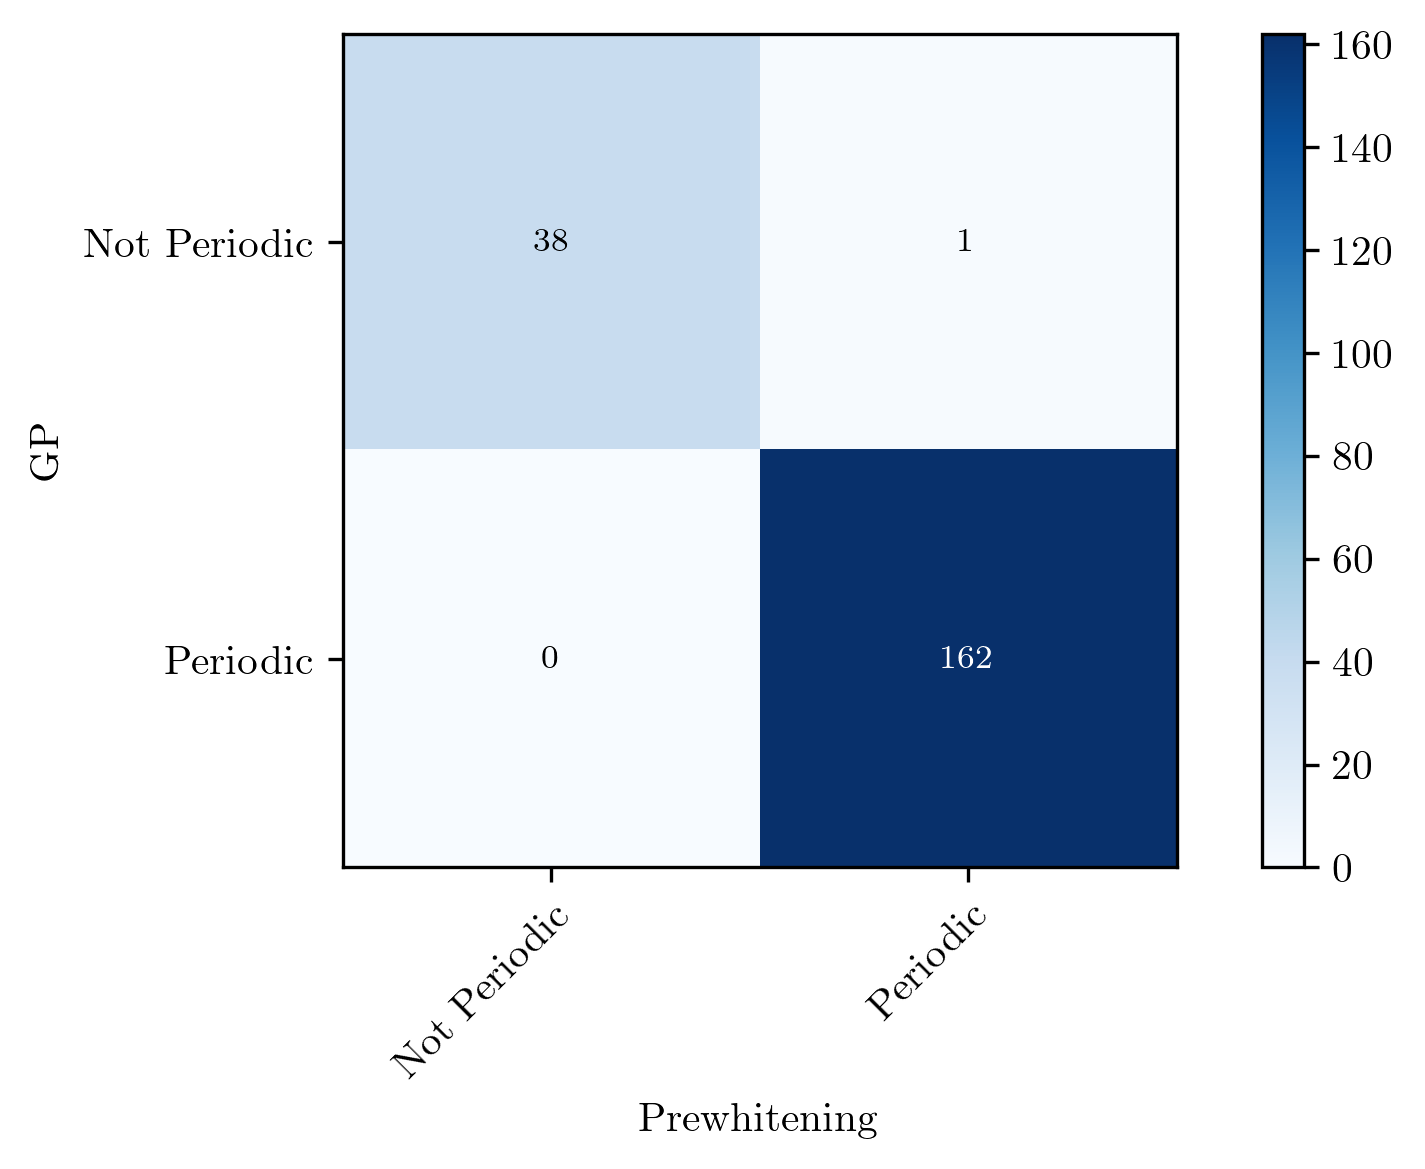

In [85]:
fig, ax = plot_confusion_matrix(y_true, y_pred, normalize=False);
fig.dpi = 300
ax.set(xlabel='Prewhitening',ylabel='GP',title='')
plt.tight_layout()